In [1]:
# Run the command below if necessary, for example with Google Colab
#!pip3 install mxnet-cu110

In [1]:
import matplotlib.pyplot as plt
import mxnet as mx
mx.random.seed(1)
import numpy as np
import pandas as pd

# Progress bar
from tqdm.notebook import tqdm

# Feature Scaling
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading data
full_house_df = pd.read_csv("kc_house_data.csv")

In [3]:
full_house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [4]:
# Only interested in teh features: living square feet, bathrooms and grade, and the output (price)
#house_df = full_house_df[["price", "sqft_living", "bathrooms", "grade"]]
house_df = full_house_df.drop(["date"], axis=1)

In [5]:
# Let's remove the outlier we found on recipe 2.1
house_df.drop(15870, inplace=True)

In [6]:
house_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
# Dataset Split 80/10/10
from sklearn.model_selection import train_test_split

full_train_df, test_df = train_test_split(house_df, test_size=0.05, random_state=42)

# To match correctly  10% size, we use previous size as reference
train_df, val_df = train_test_split(full_train_df, test_size=len(test_df), random_state=42)

In [8]:
# One-hot encoding (will be added after scaling)
# Grade goes from 1 to 13
grades_list = list(map(str, range(1, 14)))

grade_onehot_train_df = pd.get_dummies(train_df.grade, prefix='', prefix_sep='')
grade_onehot_val_df = pd.get_dummies(val_df.grade, prefix='', prefix_sep='')
grade_onehot_test_df = pd.get_dummies(test_df.grade, prefix='', prefix_sep='')

# Not all grade values might be present in the data, so we must fill those values with 0
grade_onehot_train_df = grade_onehot_train_df.T.reindex(grades_list).T.fillna(0).astype(dtype=np.float32)
grade_onehot_val_df = grade_onehot_val_df.T.reindex(grades_list).T.fillna(0).astype(dtype=np.float32)
grade_onehot_test_df = grade_onehot_test_df.T.reindex(grades_list).T.fillna(0).astype(dtype=np.float32)

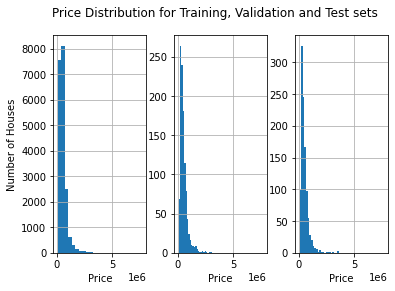

In [9]:
number_plots = 3
# In this case, sharey would not set the right scale,
# as validation and test sets are 8 time smaller
fig, axs = plt.subplots(1, number_plots, sharex = True, sharey = False)

train_df.hist(column = "price", bins = 24, ax = axs[0])
val_df.hist(column = "price", bins = 24, ax = axs[1])
test_df.hist(column = "price", bins = 24, ax = axs[2])
fig.suptitle("Price Distribution for Training, Validation and Test sets")
for i in range(number_plots):
    axs[i].set_title(None)
    axs[i].set_xlabel("Price")
axs[0].set_ylabel("Number of Houses")
plt.show()

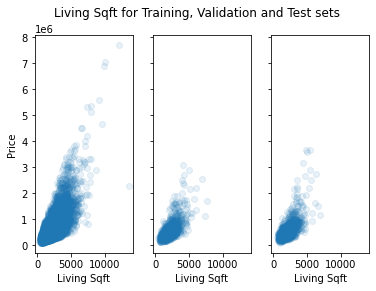

In [10]:
fig, axs = plt.subplots(1, number_plots, sharex = True, sharey = True)

axs[0].scatter(train_df["sqft_living"], train_df["price"], alpha = 0.1)
axs[1].scatter(val_df["sqft_living"], val_df["price"], alpha = 0.1)
axs[2].scatter(test_df["sqft_living"], test_df["price"], alpha = 0.1)
fig.suptitle("Living Sqft for Training, Validation and Test sets")
for i in range(number_plots):
    axs[i].set_title(None)
    axs[i].set_xlabel("Living Sqft")
axs[0].set_ylabel("Price")
plt.show()

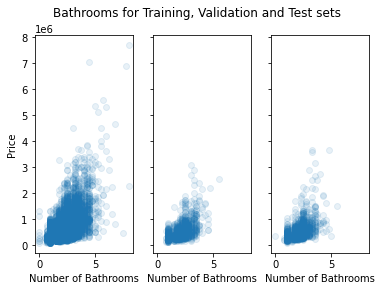

In [11]:
fig, axs = plt.subplots(1, number_plots, sharex = True, sharey = True)

axs[0].scatter(train_df["bathrooms"], train_df["price"], alpha = 0.1)
axs[1].scatter(val_df["bathrooms"], val_df["price"], alpha = 0.1)
axs[2].scatter(test_df["bathrooms"], test_df["price"], alpha = 0.1)
fig.suptitle("Bathrooms for Training, Validation and Test sets")
for i in range(number_plots):
    axs[i].set_title(None)
    axs[i].set_xlabel("Number of Bathrooms")
axs[0].set_ylabel("Price")
plt.show()

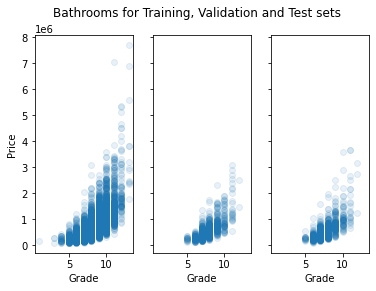

In [12]:
fig, axs = plt.subplots(1, number_plots, sharex = True, sharey = True)

axs[0].scatter(train_df["grade"], train_df["price"], alpha = 0.1)
axs[1].scatter(val_df["grade"], val_df["price"], alpha = 0.1)
axs[2].scatter(test_df["grade"], test_df["price"], alpha = 0.1)
fig.suptitle("Bathrooms for Training, Validation and Test sets")
for i in range(number_plots):
    axs[i].set_title(None)
    axs[i].set_xlabel("Grade")
axs[0].set_ylabel("Price")
plt.show()

In [13]:
print("Price Range:", house_df["price"].min(), house_df["price"].max())
print("Living Sqft Range:", house_df["sqft_living"].min(), house_df["sqft_living"].max())
print("Number of Bathrooms Range:", house_df["bathrooms"].min(), house_df["bathrooms"].max())
print("Grade Range:", house_df["grade"].min(), house_df["grade"].max())

Price Range: 75000.0 7700000.0
Living Sqft Range: 290 13540
Number of Bathrooms Range: 0.0 8.0
Grade Range: 1 13


In [14]:
# Grade not needed anymore
train_df = train_df.drop(["grade"], axis=1)
val_df = val_df.drop(["grade"], axis=1)
test_df = test_df.drop(["grade"], axis=1)

In [15]:
def scale_features(X, y):
    """
    Applies Standard Scaling to X, y
    returns scaled version of X,y
    """
    sc_X = StandardScaler()
    scaled_X = sc_X.fit_transform(X)
    sc_y = StandardScaler()
    scaled_y = sc_y.fit_transform(y)
    return scaled_X, scaled_y

In [16]:
# Data Preprocessing Training set

# Feature Scaling for Training, Validation and Testing
train_df_no_price = train_df.drop(["price"], axis=1)
val_df_no_price = val_df.drop(["price"], axis=1)
test_df_no_price = test_df.drop(["price"], axis=1)

X_train = np.array(train_df_no_price.to_numpy(), dtype=np.float32)
y_train = np.array(train_df["price"].to_numpy().reshape(-1,1), dtype=np.float32)
X_val   = np.array(val_df.drop(["price"], axis=1).to_numpy(), dtype=np.float32)
y_val   = np.array(val_df["price"].to_numpy().reshape(-1,1), dtype=np.float32)
X_test  = np.array(test_df.drop(["price"], axis=1).to_numpy(), dtype=np.float32)
y_test  = np.array(test_df["price"].to_numpy().reshape(-1,1), dtype=np.float32)

scaled_X_train, scaled_y_train = scale_features(X_train, y_train)
scaled_X_val, scaled_y_val = scale_features(X_val, y_val)
scaled_X_test, scaled_y_test = scale_features(X_test, y_test)

In [17]:
# Add One-Hot Encoding fields (no scaling for these)
scaled_X_train_df = pd.DataFrame(scaled_X_train, index=train_df_no_price.index, columns=train_df_no_price.columns)
scaled_X_val_df = pd.DataFrame(scaled_X_val, index=val_df_no_price.index, columns=val_df_no_price.columns)
scaled_X_test_df = pd.DataFrame(scaled_X_test, index=test_df_no_price.index, columns=test_df_no_price.columns)

scaled_X_train_onehot_df = pd.concat([scaled_X_train_df, grade_onehot_train_df], axis=1)
scaled_X_val_onehot_df = pd.concat([scaled_X_val_df, grade_onehot_val_df], axis=1)
scaled_X_test_onehot_df = pd.concat([scaled_X_test_df, grade_onehot_test_df], axis=1)

In [18]:
# Prepare datasets to work with DataLoader
training_set = mx.gluon.data.dataset.ArrayDataset(scaled_X_train_onehot_df.to_numpy(), scaled_y_train)
validation_set = mx.gluon.data.dataset.ArrayDataset(scaled_X_val_onehot_df.to_numpy(), scaled_y_val)
test_set = mx.gluon.data.dataset.ArrayDataset(scaled_X_test_onehot_df.to_numpy(), scaled_y_test)

#training_set = mx.gluon.data.dataset.ArrayDataset(scaled_X_train, scaled_y_train)
#validation_set = mx.gluon.data.dataset.ArrayDataset(scaled_X_val, scaled_y_val)
#test_set = mx.gluon.data.dataset.ArrayDataset(scaled_X_test, scaled_y_test)

In [19]:
# Perceptron Model (this time using Gluon)
# See Recipe 2.1
number_of_features = 14

# Perceptron with 14 inputs and 1 output as described in recipe 3.1
#net = mx.gluon.nn.Dense(1, in_units=number_of_features)
net = mx.gluon.nn.Sequential()
#net.add(mx.gluon.nn.Dense(1024, activation="relu"))
net.add(mx.gluon.nn.Dense(128, activation="relu"))
net.add(mx.gluon.nn.Dropout(.5))
#net.add(mx.gluon.nn.Dense(2048, activation="relu"))
#net.add(mx.gluon.nn.Dropout(.5))
#net.add(mx.gluon.nn.Dense(2048, activation="relu"))
#net.add(mx.gluon.nn.Dropout(.5))
net.add(mx.gluon.nn.Dense(1024, activation="relu"))
net.add(mx.gluon.nn.Dropout(.5))
net.add(mx.gluon.nn.Dense(128, activation="relu"))
net.add(mx.gluon.nn.Dropout(.5))
net.add(mx.gluon.nn.Dense(1))

In [20]:
# Training Loop 
def training_loop(loss_fn, trainer, epochs, batch_size, training_set, validation_set, test_set, ctx = mx.gpu()):
    loss_sequence = []
    min_val_loss = float("inf")
    
    # Model file name
    file_name = "net.params"
    
    # Iterator for Gluon data access
    training_data_iterator = mx.gluon.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    validation_data_iterator = mx.gluon.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
    test_data_iterator = mx.gluon.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    num_training_batches = len(training_set) / batch_size
    num_validation_batches = len(validation_set) / batch_size
    num_test_batches = len(test_set) / batch_size

    #progress_bar = tqdm(range(epochs))
    #for e in progress_bar:
    for e in tqdm(range(epochs)):
                
        cumulative_loss = 0
        # inner loop
        for data, label in training_data_iterator:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with mx.autograd.record():
                output = net(data)
                loss = loss_fn(output, label)
            loss.backward()
            trainer.step(batch_size)
            current_loss = mx.nd.mean(loss).asscalar()
            cumulative_loss += current_loss / num_training_batches
        
        # Validation Loss
        cumulative_val_loss = 0
        for data, label in validation_data_iterator:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            output = net(data)
            val_loss = loss_fn(output, label)
            current_val_loss = mx.nd.mean(val_loss).asscalar()
            cumulative_val_loss += current_val_loss / num_validation_batches
            
        # Test Loss
        cumulative_test_loss = 0
        for data, label in test_data_iterator:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            output = net(data)
            test_loss = loss_fn(output, label)
            current_test_loss = mx.nd.mean(test_loss).asscalar()
            cumulative_test_loss += current_test_loss / num_test_batches
            
        added_info = ""
        if cumulative_val_loss < min_val_loss:
            added_info = " --- Updating saved model"
            min_val_loss = cumulative_val_loss
            net.save_parameters(file_name)
            
        #desc = f"E: {e:4d}, TrL: {cumulative_loss:8.6f}, VL: {cumulative_val_loss:8.6f}, TL: {cumulative_test_loss:8.6f}" + added_info
        loss_sequence.append(cumulative_loss)
               
        #progress_bar.set_description(desc)

In [23]:
# Initialization
#ctx = mx.gpu()
cts = mx.cpu()
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)

In [24]:
# Define Loss Function
loss_fn = mx.gluon.loss.HuberLoss()
#loss_fn = mx.gluon.loss.L1Loss()
#loss_fn = mx.gluon.loss.L2Loss()

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(net.collect_params(), "adam", {"learning_rate": 0.001})
#trainer = mx.gluon.Trainer(net.collect_params(), "sgd", {"learning_rate": 0.0001})

# Epochs & Batch Size
epochs = 600
batch_size = 64

training_loop(loss_fn, trainer, epochs, batch_size, training_set, validation_set, test_set, ctx)

  0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Input features of an example
scaled_example_input = mx.nd.array([scaled_X_train[0]])

In [ ]:
# Expected output of the example (price)
expected_output = y_train[0]
print(expected_output)
scaled_expected_output = mx.nd.array([scaled_y_train[0]])
print(scaled_expected_output)

In [ ]:
# Calculate the prediction of our model
output = net(scaled_example_input.as_in_context(ctx))
print(output)

In [ ]:
# Unscaled Expected Output
print("Unscaled Expected Output:", sc_y.inverse_transform(scaled_expected_output.asnumpy()))

# Unscaled Output
print("Unscaled Output:", sc_y.inverse_transform(output.asnumpy()))